# Метод Ньютона (20 баллов)

In [4]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import math
import time


seed = 42
rng = np.random.default_rng(seed)

Вспомним основные свойства логистической регрессии с кросс-энтропийной функцией потерь:
1. Модель:

$$
g(x, a_i) = \frac{1}{1 + \exp \left[- \langle x, a_i \rangle\right]};
$$

2. Функция потерь:

$$
\ell(g(x, a_i), b_i) = -b_i \log \left[g(x, a_i)\right] - (1 - b_i) \log \left[1 -  g(x, a_i)\right].
$$

3. Полный вид оптимизационной задачи:

$$
\min_{x \in \mathbb{R}^d} \left[ f(x) = \frac{1}{n} \sum_{i=1}^n \ell \left(g(x, a_i), b_i \right) + \frac{\lambda}{2} \| x \|^2_2 \right],
$$

4. Градиент функции потерь:

$$
\nabla f(x) = \frac{1}{n} \sum_{i=1}^n (g(x, a_i) - b_i) a_i + \lambda x.
$$

5. Гессиан функции потерь:

$$
\nabla^2 f(x) = \frac{1}{n} \sum_{i=1}^n g(x, a_i)(1 - g(x, a_i)) a_i a_i^\top + \lambda I_d.
$$
   
6. Константа $L$-гладкости оценивается как

$$
L \geq \frac{1}{4n} \lambda_{\max} \left[A^\top A \right] + \lambda,
$$

7. Константа $\mu$-сильной выпуклости оценивается как $\mu \leq \lambda$.

В качестве дата-матрицы $A$ и целевого вектора $b$ рассмотрим данные из датасета [_mushrooms_](https://github.com/BRAIn-Lab-teaching/OPTIMIZATION-METHODS-COURSE/blob/ПМИ_осень_2025/Datasets/mushrooms.txt). Ниже представлена функция загрузки датасета.

In [5]:
url = "https://raw.githubusercontent.com/BRAIn-Lab-teaching/OPTIMIZATION-METHODS-COURSE/%D0%9F%D0%9C%D0%98_%D0%BE%D1%81%D0%B5%D0%BD%D1%8C_2025/Datasets/mushrooms.txt"
!wget -O mushrooms.txt "$url"

--2025-10-30 15:03:48--  https://raw.githubusercontent.com/BRAIn-Lab-teaching/OPTIMIZATION-METHODS-COURSE/%D0%9F%D0%9C%D0%98_%D0%BE%D1%81%D0%B5%D0%BD%D1%8C_2025/Datasets/mushrooms.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879712 (859K) [text/plain]
Saving to: ‘mushrooms.txt’

mushrooms.txt       100%[===================>] 859.09K  --.-KB/s    in 0.006s  

2025-10-30 15:03:48 (143 MB/s) - ‘mushrooms.txt’ saved [879712/879712]



In [6]:
from sklearn.datasets import load_svmlight_file

#файл должен лежать в той же директории, что и notebook
dataset = "mushrooms.txt"

data = load_svmlight_file(dataset)
A, b = data[0].toarray(), data[1]

# Необходимое линейное преобразование
b = b - 1

С помощью функции ```train_test_split``` разделите датасет в отношении 4 к 1 (обучающая выборка должна быть в 4 раза больше, чем тестовая). Поставьте параметр ```random_state = 57```. В дальнейшем мы будем валидировать процесс обучения на тестовой выборке.

In [17]:
# Ваше решение (Code)

from sklearn.model_selection import train_test_split
A_train, A_test, b_train, b_test= train_test_split(A,b, test_size= 1/5, random_state= 57, shuffle= True)

n= A_train.shape[0]
s_max= np.linalg.svd(A_train, compute_uv=False)[0]
L= (s_max**2) / (4.0*n)
lam= L/1000.0
mu= lam

Для обучающей части $A_{train}$, $b_{train}$ оцените константы $L$ и $\mu$, положив равенство в полученной ранее оценке. Задайте $\lambda$ так, чтобы $\lambda \approx L / 1000$.

In [18]:
# Ваше решение (Code)
assert math.isclose(L, 2.586914976545057,  rel_tol=1e-6),  "Константа L-гладкости найдена неверно"
assert math.isclose(mu, 0.002586914976545057, rel_tol=1e-6),  "Константа регуляризации найдена неверно"

Дополните функции подсчета сигмоиды, кросс-энтропии, градиента и гессиана оптимизируемой функции.

In [19]:
def sigmoid(x):
    """
    Вычисляет сигмоидную функцию.

    Параметры:
        x (np.array): Входное значение

    Возвращает:
        sigmoid (np.array) Значение сигмоидной функции для входных данных
    """

    z= np.clip(x, -709.0, 709.0)
    res= 1.0/(1.0+np.exp(-z))
    return res


def loss(x, A=A_train, b=b_train, lambda_value=L/1000):
    """
    Вычисляет значение эмпирического риска.

    Параметры:
        x (np.array): Вектор параметров модели
        A (np.array): Матрица признаков обучающей выборки
        b (np.array): Вектор меток обучающей выборки
        lambda_value (float): Параметр регуляризации

    Возвращает:
        loss (float): Значение функции потерь
    """

    # YOUR CODE HERE

    n= A.shape[0]
    z= A@x
    g= sigmoid(z)
    eps= 1e-12
    emp= -np.mean(b*np.log(g+eps) + (1.0-b)*np.log(1.0-g+eps))
    loss= emp+0.5*lambda_value*np.dot(x, x)

    return loss




def grad(x, A=A_train, b=b_train, lambda_value=L/1000):
    """
    Вычисляет градиент функции потерь.

    Параметры:
        x (np.array): Вектор параметров модели
        A (np.array): Матрица признаков обучающей выборки
        b (np.array): Вектор меток обучающей выборки
        lambda_value (float): Параметр регуляризации

    Возвращает:
        grad (np.array): Градиент функции потерь
    """

    # YOUR CODE HERE


    n= A.shape[0]
    g= sigmoid(A @ x)
    grad= (A.T@(g-b))/n + lambda_value*x

    return grad




def hess(x, A=A_train, b=b_train, lambda_value=L/1000):
    """
    Вычисляет гессиан функции потерь.

    Параметры:
        x (np.array): Вектор параметров модели
        A (np.array): Матрица признаков обучающей выборки
        b (np.array): Вектор меток обучающей выборки
        lambda_value (float): Параметр регуляризации

    Возвращает:
        hess (np.array): Гессиан функции потерь.
    """

    n= A.shape[0]
    g= sigmoid(A@x)
    w= g*(1.0-g)
    Aw= A*w[:, None]
    hess= (A.T@Aw)/n + lambda_value*np.eye(A.shape[1])

    # YOUR CODE HERE

    return hess

В качестве критерия сходимости используем норму градиента.

In [20]:
def criterion(x, A=A_train, b=b_train, lambda_value=L/1000):
    """
    Вычисляет критерий остановки.

    Параметры:
        x (np.array): Текущая точка
        A (np.array): Матрица признаков
        b (np.array): Вектор меток
        lambda_value (float): Параметр регуляризации

    Возвращает:
        norm (float): Норма градиента
    """
    return np.linalg.norm(grad(x,A,b, lambda_value))

## Основная часть (10 баллов)

__Задача 1.__ Начнем с демпфированного метода Ньютона (с возможностью выбора шага).


**Псевдокод алгоритма**

---

_Инициализация:_

- Размер шага $\{ \gamma_k \}_{k=0} > 0$
- Начальная точка $x^0 \in \mathbb{R}^d$
- Максимальное число итераций $K$

---

$k$_-ая итерация:_

$$x^{k+1} = x^k - \gamma_k \left(\nabla^2 f\left(x^k\right)\right)^{-1} \nabla f\left(x^k\right)$$

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$ или $\frac{\| \nabla f(x^k) \|_2}{\| \nabla f(x^0) \|_2} < \varepsilon$

---

_Выход:_
- Полученное значение $x^K$

__а)(2 балла)__ Допишите метод `damped_newton`.

_Замечание: вычисление обратной матрицы и последующее перемножение не являются оптимальным (с точки зрения временных затрат) способом найти нужное направление для шага. Подумайте, как можно было бы реализовать поиск направления с помощью одной функции из библиотеки `numpy.linalg`._

In [21]:
def damped_newton(A, b, lambda_value, grad, hess, criterion, x_0, eps=1e-8, max_iter=1000, **params):
    """
    Реализация демпфированного метода Ньютона.

    Параметры:
        A (np.array): Матрица признаков.
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        grad (Callable): Функция вычисления градиента
        hess (Callable): Функция вычисления гессиана
        criterion (Callable): Функция критерия остановки
        x_0 (np.array): Начальная точка
        eps (float): Точность сходимости (критерий остановки)
        max_iter (int): Максимальное количество итераций
        params : Именованные гиперпараметры метода
            params['gamma'] : шаг

    Возвращает:
        x_k (np.array) : Найденное решение
        times (list) : Список значений времени на каждой итерации
        errors (list) : Список значений критерия сходимости на каждой итерации
    """
    times = []
    errors = []

    x_k = np.copy(x_0)
    start = time.time()
    times.append(start - start)
    err_0 = criterion(x_0, A, b, lambda_value)
    errors.append(criterion(x_k, A, b, lambda_value) / err_0)

    gamma = params.get('gamma', 1.0)

    for k in tqdm(range(max_iter)):






        # YOUR CODE HERE
        gk= grad(x_k, A, b, lambda_value)
        Hk= hess(x_k, A, b, lambda_value)

        try:
            p = np.linalg.solve(Hk, gk)
        except np.linalg.LinAlgError:
            p = np.linalg.solve(Hk + 1e-8 * np.eye(Hk.shape[0]), gk) #

        x_k = x_k - gamma*p









        times.append(time.time() - start)
        errors.append(criterion(x_k, A, b, lambda_value) / err_0)

        if errors[-1] < eps:
            break

    return x_k, times, errors

Запустите демпфированный метод Ньютона c шагом $\gamma_k = 1.0$ для следующих начальных приближений:
1. $x_0 = (0, \ldots, 0)^\top$ (вектор из всех нулей);
2. $x_0 = (1, \ldots, 1)^\top$ (вектор из всех единиц);
3. $x_0 = (2, \ldots, 2)^\top$ (вектор из всех двоек).

In [41]:
# Ваше решение (Code)
d= A_train.shape[1]
x0_0= np.zeros(d)
x0_1= np.ones(d)
x0_2= 2.0 * np.ones(d)
xk_0,t_0,e_0= damped_newton(A_train, b_train, L/1000, grad, hess, criterion, x0_0, eps=1e-8, max_iter=20, gamma=1.0)
xk_1,t_1,e_1= damped_newton(A_train, b_train, L/1000, grad, hess, criterion, x0_1, eps=1e-8, max_iter=20, gamma=1.0)
xk_2,t_2,e_2= damped_newton(A_train, b_train, L/1000, grad, hess, criterion, x0_2, eps=1e-8, max_iter=20, gamma=1.0)

100%|██████████| 20/20 [00:01<00:00, 18.44it/s]


Постройте график сходимости.

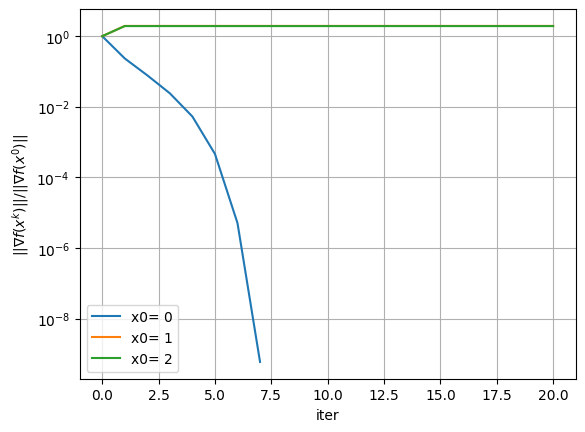

In [43]:
# Ваше решение (Code)
plt.plot(e_0, label='x0= 0')
plt.plot(e_1, label='x0= 1')
plt.plot(e_2, label='x0= 2')
plt.yscale('log')
plt.xlabel('iter')
plt.ylabel('$||∇f(x^k)||/||∇f(x^0)||$')
plt.grid()
plt.legend()
plt.show()

Согласуются ли полученные результаты с теорией?

In [ ]:
# Ваше решение (Markdown)

# **Ответ:**
Нет сходимости при $x_0 = (2, ..., 2)^T$, согласуются <br>
Метод Ньютона имеет локальную сходимость, при этом начальном приближении мы находимся слишком далеко от решения <br>
Возможно, мы делаем слишком большой начальный шаг<br>

__б)(2 балла)__ Чтобы улучшить сходимость, сделаем несколько начальных итераций с помощью метода градиентного спуска, а потом уже запустим метод Ньютона. Допишите код в методе `gd_dn`.

In [44]:
def gd_dn(A, b, lambda_value, grad, hess, criterion, x_0, eps=1e-8, max_iter=10, gd_max_iter=20, **params):
    """
    Реализация метода: сначала градиентный спуск, затем демпфированный метод Ньютона.

    Параметры:
        A (np.array): Матрица признаков.
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        grad (Callable): Функция вычисления градиента
        hess (Callable): Функция вычисления гессиана
        criterion (Callable): Функция критерия остановки
        x_0 (np.array): Начальная точка
        eps (float): Точность сходимости (критерий остановки)
        max_iter (int): Максимальное количество итераций метода Ньютона
        gd_max_iter (int): Количество итераций градиентного спуска
        params : Именованные гиперпараметры метода
            params['gamma_gd']: шаг на итерации градиентного спуска
            params['gamma_newton']: шаг на итерации метода Ньютона

    Возвращает:
        x_k (np.array) : Найденное решение
        times (list) : Список значений времени на каждой итерации
        errors (list) : Список значений критерия сходимости на каждой итерации
    """
    times = []
    errors = []

    x_k = np.copy(x_0)
    start = time.time()
    times.append(start - start)
    err_0 = criterion(x_0, A, b, lambda_value)
    errors.append(criterion(x_k, A, b, lambda_value) / err_0)

    # Извлечение параметров
    gamma_gd = params.get('gamma_gd', 1e-3)
    gamma_newton = params.get('gamma_newton', 1.0)

    # === Этап 1: Градиентный спуск ===
    for k in tqdm(range(gd_max_iter), desc="GD phase"):




        # YOUR CODE HERE
        gk= grad(x_k,A,b,lambda_value)
        x_k= x_k-gamma_gd*gk










        times.append(time.time() - start)
        errors.append(criterion(x_k, A, b, lambda_value) / err_0)

    # === Этап 2: Демпфированный метод Ньютона ===
    for k in tqdm(range(max_iter), desc="Newton phase"):







        # YOUR CODE HERE
        gk= grad(x_k, A, b, lambda_value)
        Hk= hess(x_k, A, b, lambda_value)
        try:
            p= np.linalg.solve(Hk, gk)
        except np.linalg.LinAlgError:
            p= np.linalg.solve(Hk+1e-8*np.eye(Hk.shape[0]), gk)
        x_k= x_k-gamma_newton*p






        times.append(time.time() - start)
        errors.append(criterion(x_k, A, b, lambda_value) / err_0)

        if errors[-1] < eps:
            break

    return x_k, times, errors

Запустите улучшенный алгоритм с теми же стартовыми точками.

In [57]:
# Ваше решение (Code)
d= A_train.shape[1]
x0_0= np.zeros(d)
x0_1= np.ones(d)
x0_2= 2.0 * np.ones(d)

gd_params = {'gamma_gd': 0.9 / (L + lam), 'gamma_newton': 1.0}

xg0, t0, e0 = gd_dn(A_train, b_train, lam, grad, hess, criterion, x0_0, eps=1e-8, max_iter=10, gd_max_iter=20, **gd_params)
xg1, t1, e1 = gd_dn(A_train, b_train, lam, grad, hess, criterion, x0_1, eps=1e-8, max_iter=10, gd_max_iter=20, **gd_params)
xg2, t2, e2 = gd_dn(A_train, b_train, lam, grad, hess, criterion, x0_2, eps=1e-8, max_iter=10, gd_max_iter=20, **gd_params)

Newton phase: 100%|██████████| 10/10 [00:00<00:00, 25.12it/s]


Постройте график сходимости.

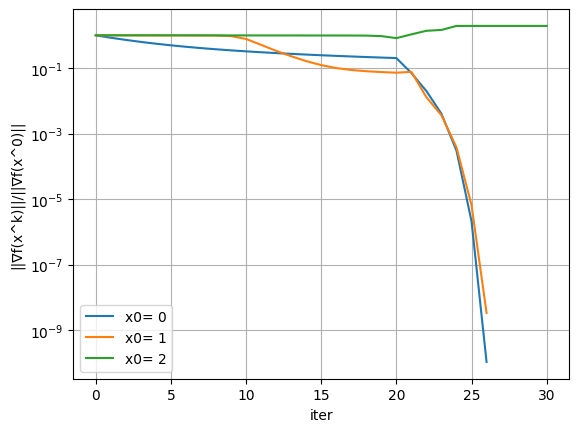

In [58]:
# Ваше решение (Code)
plt.plot(e0, label='x0= 0')
plt.plot(e1, label='x0= 1')
plt.plot(e2, label='x0= 2')
plt.xlabel('iter')
plt.ylabel('$||∇f(x^k)||/||∇f(x^0)||$')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

Напишите вывод.

In [ ]:
# Ваше решение (Markdown)

# **Ответ:**
В начале градиент маленький из-за сигмоиды <br>
При  $x_0 = (2, ..., 2)^T$ расходится, так как всё ещё далеко от решения. Помогло бы изменение шага.<br>

__Задача 2.__ Вычисление обратной матрицы гессиана является крайне ресурсоемким, поэтому предлагается использовать вместо её точного значения некоторую аппроксимацию невырожденной положительно определенной матрицей. Такие методы называются *квазиньютоновскими*. В данной части будут рассмотрены два основных алгоритма.

__Псевдокод алгоритма__

---

_Инициализация:_

- Размер шага $\{ \gamma_k \}_{k=0} > 0$
- Начальная точка $x^0 \in \mathbb{R}^d$
- Начальное приближение обратной матрицы Гессиана $H_0 = I_d$
- Максимальное число итераций $K$

---

$k$_-ая итерация:_

1. Сделать шаг спуска:

   $$
   x^{k+1} = x^k - \gamma_k H_k \nabla f(x^k)
   $$

2. Обновить $H_k$

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$ или $\frac{\| \nabla f(x^k) \|_2}{\| \nabla f(x^0) \|_2} < \varepsilon$

---

_Выход:_
- Полученное значение $x^K$

__а) (2 балла)__ Реализуйте квазиньютоновский метод BFGS, с обновлением шага:

$$
H_{k+1} = \left( I - \frac{s_k y_k^T}{y_k^T s_k} \right) H_k \left( I - \frac{y_k s_k^T}{y_k^T s_k} \right) + \frac{s_k s_k^T}{y_k^T s_k}.
$$

Искать $\gamma_k$ будем с помощью метода Вульфа.

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^k$
- Начальная точка $\gamma_0 > 0$
- Направление спуска $h^k$
- Максимальное число итераций $K$
- Множитель уменьшения шага $m \in (0, 1)$
- Параметры $\beta_1, \beta_2 \in (0, 1)$

---

1. Проверить условие Армихо:

$$
f\left(x^k + \gamma_k h^k\right) \leq f\left(x^k\right) + \beta_1 \gamma_k \langle \nabla f\left(x^k\right), h^k \rangle
$$

2. Проверить условие кривизны

$$
\langle \nabla f \left(x^k + \gamma_k h^k\right),  h^k \rangle \geq \beta_2 \langle \nabla f \left(x^k\right), h^k \rangle
$$

2. Если оба условия выполняются, вернуть $\gamma_k$. Если не выполняется Армихо — уменьшить шаг:

    $$\gamma_k = \gamma_k \cdot m$$

    и вернуться к 1. Иначе — увеличить шаг:

    $$\gamma_k = \gamma_k / m$$

    и вернуться к 1

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$

---

_Выход:_
- Полученное значение $\gamma_k$

In [65]:
def wolfe(A, b, lambda_value, loss, grad, x, h, beta1, beta2, gamma_mult, max_iters, gamma0):
    """
    Правило Вольфа.

    Параметры:
        A (np.array): Матрица признаков
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        loss (Callable): Функция потерь
        grad (Callable): Функция вычисления градиента
        x (np.array): Текущая точка
        h (np.array): Направление спуска
        beta1 (float): Параметр условия достаточного убывания
        beta2 (float): Параметр кривизны
        gamma_mult (float): Множитель уменьшения шага
        max_iters (int): Максимальное число итераций подбора
        gamma0 (float): Начальное значение шага

    Возвращает:
        gamma (float): Найденное значение шага, удовлетворяющее условию Вольфа
    """
    gamma = gamma0
    counter = 0
    current_loss = loss(x, A, b, lambda_value)
    grad_x = grad(x, A, b, lambda_value)
    directional_derivative = grad_x.dot(h)

    while counter < max_iters:







        # YOUR CODE HERE
        x_new= x+gamma*h

        new_loss= loss(x_new, A, b, lambda_value)
        grad_new= grad(x_new, A, b, lambda_value)
        dir_deriv_new= grad_new.dot(h)

        armijo= new_loss<= current_loss+beta1*gamma*directional_derivative
        curv= dir_deriv_new>= beta2*directional_derivative

        if armijo and curv:
            break
        if not armijo:
            gamma*= gamma_mult
        else:
            gamma/= gamma_mult

        counter+= 1












    return gamma

Запустите метод `bfgs` для трех различных начальных точек.

In [62]:
def bfgs(A, b, lambda_value, loss, grad, criterion, x_0, eps=1e-16, max_iter=100, **params):
    """
    Реализация квази-ньютоновского метода BFGS.

    Параметры:
        A (np.array): Матрица признаков размерности
        b (np.array): Вектор целевых значений размерности
        lambda_value (float): Параметр регуляризации
        loss (Callable): Функция потерь
        grad (Callable): Функция вычисления градиента
        criterion (Callable): Функция критерия остановки
        x_0 (np.array): Начальная точка оптимизации
        eps (float): Точность сходимости
        max_iter (int): Максимальное количество итераций
        params (dict): Дополнительные параметры для line_search:
            params['beta1'] (float): Первый параметр
            params['beta2'] (float): Второй параметр (не используется в правиле Армихо)
            params['gamma_mult'] (float): Множитель для уменьшения шага
            params['line_search_max_iter'] (int): Максимальное число итераций подбора шага
            params['gamma0'] (float): Начальное значение шага

    Возвращает:
        x_k (np.array): Найденное решение
        times (list): Список значений времени на каждой итерации
        errors (list): История значений критерия сходимости
    """
    times = []
    errors = []

    x_k = np.copy(x_0)
    start = time.time()
    times.append(start - start)
    err_0 = criterion(x_0, A, b, lambda_value)
    errors.append(criterion(x_k, A, b, lambda_value) / err_0)

    n = x_k.shape[0]
    H_k = np.eye(n)  # Инициализируем обратный гессиан как единичную матрицу

    beta1 = params.get('beta_1', 1e-4)
    beta2 = params.get('beta_2', 0.9)
    gamma_mult = params.get('gamma_mult', 0.5)
    line_search_max_iter = params.get('line_search_max_iter', 20)
    gamma0 = params.get('gamma0', 1.0)

    for k in tqdm(range(max_iter)):









        # YOUR CODE HERE
        gk= grad(x_k, A, b, lambda_value)
        h_k= -H_k@gk

        gamma= wolfe(A, b, lambda_value, loss, grad, x_k, h_k, beta1, beta2,
                      gamma_mult, line_search_max_iter, gamma0)
        x_next= x_k+gamma*h_k

        s_k= x_next-x_k
        g_next= grad(x_next, A, b, lambda_value)
        y_k= g_next - gk
        yTs= float(y_k @ s_k)

        rho= 1.0 / yTs
        I= np.eye(n)
        V= I - rho * np.outer(s_k, y_k)
        H_k= V@H_k@V.T + rho *np.outer(s_k, s_k)

        x_k= x_next















        times.append(time.time() - start)
        errors.append(criterion(x_k, A, b, lambda_value) / err_0)

        if errors[-1] < eps:
            break

    return x_k, times, errors

In [68]:
# Ваше решение (Code)
d= A_train.shape[1]
x0_0= np.zeros(d)
x0_1= np.ones(d)
x0_2= 2.0 * np.ones(d)

bfgs_params= {'beta_1': 1e-4, 'beta_2': 0.9, 'gamma_mult': 0.5, 'line_search_max_iter': 50, 'gamma0': 1.0}

xb0,tb0,eb0= bfgs(A_train, b_train, lam, loss, grad, criterion, x0_0, eps=1e-8, max_iter=200, **bfgs_params)
xb1,tb1,eb1= bfgs(A_train, b_train, lam, loss, grad, criterion, x0_1, eps=1e-8, max_iter=200, **bfgs_params)
xb2,tb2,eb2= bfgs(A_train, b_train, lam, loss, grad, criterion, x0_2, eps=1e-8, max_iter=200, **bfgs_params)

 74%|███████▎  | 147/200 [00:00<00:00, 190.65it/s]


Постройте сравнительные графики с демпфированным методом Ньютона с градиентным спуском. Сравнения должны быть проведены как по итерациям, так и по времени.

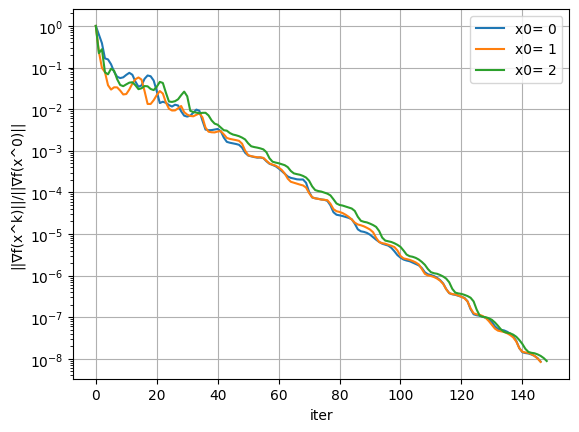

In [69]:
# Ваше решение (Code)
plt.plot(eb0, label='x0= 0')
plt.plot(eb1, label='x0= 1')
plt.plot(eb2, label='x0= 2')
plt.xlabel('iter')
plt.ylabel('$||∇f(x^k)||/||∇f(x^0)||$')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

__б) (2 балла)__ Аппроксимация BFGS далеко не единственная. Поэтому также предлагается рассмотреть метод SR1 со следующим обновлением обратного гессиана:

$$
H_{k + 1} = H_k + \frac{(s_k - H_k y_k)(s_k - H_k y_k)^\top}{(s_k - H_k y_k)^\top y_k}.
$$

In [80]:
def sr1(A, b, lambda_value, loss, grad, criterion, x_0, eps=1e-16, max_iter=100, **params):
    """
    Реализация квази-ньютоновского метода SR1.

    Параметры:
        A (np.array): Матрица признаков размерности
        b (np.array): Вектор целевых значений размерности
        lambda_value (float): Параметр регуляризации
        loss (Callable): Функция потерь
        grad (Callable): Функция вычисления градиента
        criterion (Callable): Функция критерия остановки
        x_0 (np.array): Начальная точка оптимизации
        eps (float): Точность сходимости
        max_iter (int): Максимальное количество итераций
        params (dict): Дополнительные параметры для line_search:
            params['beta1'] (float): Первый параметр
            params['beta2'] (float): Второй параметр (не используется в правиле Армихо)
            params['gamma_mult'] (float): Множитель для уменьшения шага
            params['line_search_max_iter'] (int): Максимальное число итераций подбора шага
            params['gamma0'] (float): Начальное значение шага

    Возвращает:
        x_k (np.array): Найденное решение
        times (list): Список значений времени на каждой итерации
        errors (list): История значений критерия сходимости
    """
    times = []
    errors = []

    x_k = np.copy(x_0)
    start = time.time()
    times.append(start - start)
    err_0 = criterion(x_0, A, b, lambda_value)
    errors.append(criterion(x_k, A, b, lambda_value) / err_0)

    n = x_k.shape[0]
    H_k = np.eye(n)  # Инициализируем обратный гессиан как единичную матрицу

    beta1 = params.get('beta_1', 1e-4)
    beta2 = params.get('beta_2', 0.9)
    gamma_mult = params.get('gamma_mult', 0.5)
    line_search_max_iter = params.get('line_search_max_iter', 20)
    gamma0 = params.get('gamma0', 1.0)

    for k in tqdm(range(max_iter)):










        # YOUR CODE HERE
        gk= grad(x_k, A, b, lambda_value)

        h_k= -H_k@gk

        gamma= wolfe(A, b, lambda_value, loss, grad, x_k, h_k, beta1, beta2,
                      gamma_mult, line_search_max_iter, gamma0)
        x_next= x_k + gamma*h_k

        s_k= x_next-x_k
        g_next= grad(x_next, A, b, lambda_value)
        y_k= g_next-gk
        v_k= s_k-H_k@y_k

        x_k= x_next

















        times.append(time.time() - start)
        errors.append(criterion(x_k, A, b, lambda_value) / err_0)

        if errors[-1] < eps:
            break

    return x_k, times, errors

Запустите метод `sr1` для трех различных начальных точек.

In [81]:
# Ваше решение (Code)

d= A_train.shape[1]
x0_0= np.zeros(d)
x0_1= np.ones(d)
x0_2= 2.0*np.ones(d)

sr1_params = {'beta_1': 1e-4, 'beta_2': 0.9, 'gamma_mult': 0.5, 'line_search_max_iter': 50, 'gamma0': 1.0}

xs0,ts0,es0= sr1(A_train, b_train, lam, loss, grad, criterion, x0_0, eps=1e-8, max_iter=200, **sr1_params)
xs1,ts1,es1= sr1(A_train, b_train, lam, loss, grad, criterion, x0_1, eps=1e-8, max_iter=200, **sr1_params)
xs2,ts2,es2= sr1(A_train, b_train, lam, loss, grad, criterion, x0_2, eps=1e-8, max_iter=200, **sr1_params)

100%|██████████| 200/200 [00:15<00:00, 12.96it/s]


Постройте сравнительные графики `bfgs` и `sr1` по числу итераций и времени.

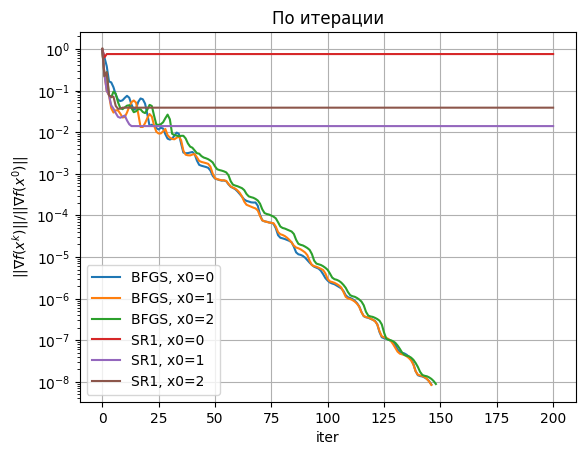

In [82]:
# Ваше решение (Code)
plt.plot(eb0, label='BFGS, x0=0')
plt.plot(eb1, label='BFGS, x0=1')
plt.plot(eb2, label='BFGS, x0=2')
plt.plot(es0, label='SR1, x0=0')
plt.plot(es1, label='SR1, x0=1')
plt.plot(es2, label='SR1, x0=2')
plt.xlabel('iter')
plt.ylabel('$||∇f(x^k)||/||∇f(x^0)||$')
plt.yscale('log')
plt.title("По итерации")
plt.grid()
plt.legend()
plt.show()

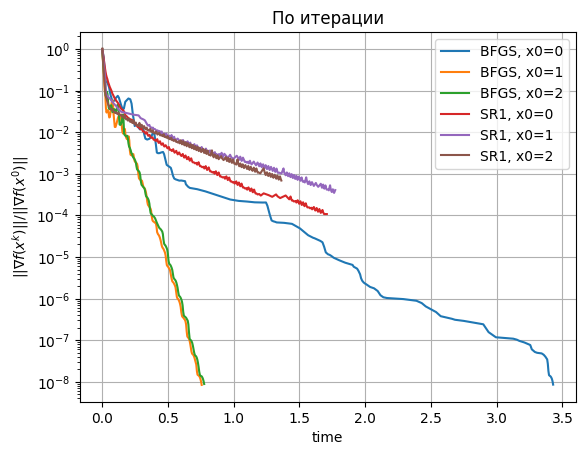

In [76]:
# Ваше решение (Code)
plt.plot(tb0, eb0, label='BFGS, x0=0')
plt.plot(tb1, eb1, label='BFGS, x0=1')
plt.plot(tb2, eb2, label='BFGS, x0=2')
plt.plot(ts0, es0, label='SR1, x0=0')
plt.plot(ts1, es1, label='SR1, x0=1')
plt.plot(ts2, es2, label='SR1, x0=2')
plt.xlabel('time')
plt.ylabel('$||∇f(x^k)||/||∇f(x^0)||$')
plt.yscale('log')
plt.title("По итерации")
plt.grid()
plt.legend()
plt.show()

__в) (2 балла)__ Сравните работу `bfgs` и `sr1` с ускоренным методом Нестерова.

In [83]:
def NAG(A, b, lambda_value, grad, criterion, x_0, eps=1e-8, max_iter=1000, **params):
    """
    Реализация метода ускоренного градиента Нестерова.

    Параметры:
        A (np.array): Матрица признаков
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        grad (Callable): Функция вычисления градиента в точке
        criterion (Callable): Функция критерия остановки
        x_0 (np.array): Начальная точка оптимизации
        eps (float): Точность сходимости (критерий остановки)
        max_iter (int): Максимальное количество итераций
        params : Именованные гиперпараметры метода
            params['gamma'] : функция шага на k-ой итерации
            params['tau'] : функция момента на k-ой итерации

    Возвращает:
        x_k (np.array) : Найденное решение
        times (list) : Список значений времени на каждой итерации
        errors (list) : Список значений критерия сходимости на каждой итерации
    """
    times = []
    errors = []

    x_k = np.copy(x_0)
    x_k_old = np.copy(x_0)
    start = time.time()
    times.append(start - start)
    err_0 = criterion(x_0, A, b, lambda_value)
    errors.append(criterion(x_k, A, b, lambda_value) / err_0)

    for k in tqdm(range(max_iter)):








        # YOUR CODE HERE
        tau_k= float(params['tau'](k))
        y_k= x_k+tau_k*(x_k-x_k_old)

        gk= grad(y_k, A, b, lambda_value)
        gamma_k= float(params['gamma'](k))

        x_next= y_k-gamma_k*gk
        x_k_old, x_k= x_k, x_next






        times.append(time.time() - start)
        errors.append(criterion(x_k, A, b, lambda_value) / err_0)

        if errors[-1] < eps:
            break

    return x_k, times, errors

In [84]:
# Ваше решение (Code)
d= A_train.shape[1]
x0_0= np.zeros(d)
x0_1= np.ones(d)
x0_2= 2.0 * np.ones(d)

gamma_const= 1.0/(L+lam)
gamma_fn= lambda k, g=gamma_const: g

def make_tau():
    t = {'v': 1.0}
    def tau(k):
        t_next= (1.0 + np.sqrt(1.0+4.0*t['v']**2))/2.0
        val= (t['v']-1.0)/t_next
        t['v']= t_next
        return val
    return tau

tau0, tau1, tau2= make_tau(), make_tau(), make_tau()

nag_params0= {'gamma': gamma_fn, 'tau': tau0}
nag_params1= {'gamma': gamma_fn, 'tau': tau1}
nag_params2= {'gamma': gamma_fn, 'tau': tau2}

xn0,tn0,en0= NAG(A_train, b_train, lam, grad, criterion, x0_0, eps=1e-8, max_iter=200, **nag_params0)
xn1,tn1,en1= NAG(A_train, b_train, lam, grad, criterion, x0_1, eps=1e-8, max_iter=200, **nag_params1)
xn2,tn2,en2= NAG(A_train, b_train, lam, grad, criterion, x0_2, eps=1e-8, max_iter=200, **nag_params2)

100%|██████████| 200/200 [00:00<00:00, 766.57it/s]


Постройте графики сходимости от количества итераций и от времени.

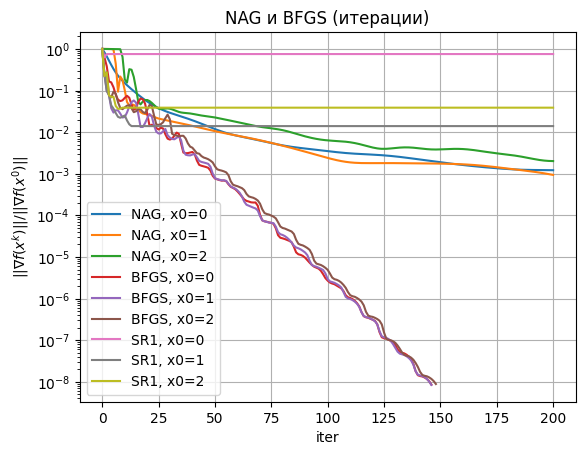

In [85]:
# Ваше решение (Code)
plt.plot(en0, label='NAG, x0=0')
plt.plot(en1, label='NAG, x0=1')
plt.plot(en2, label='NAG, x0=2')
plt.plot(eb0, label='BFGS, x0=0')
plt.plot(eb1, label='BFGS, x0=1')
plt.plot(eb2, label='BFGS, x0=2')
plt.plot(es0, label='SR1, x0=0')
plt.plot(es1, label='SR1, x0=1')
plt.plot(es2, label='SR1, x0=2')
plt.yscale('log')

plt.xlabel('iter')
plt.ylabel('$||∇f(x^k)||/||∇f(x^0)||$')
plt.title('NAG и SR,BFGS (итерации)')
plt.grid()
plt.legend()
plt.show()

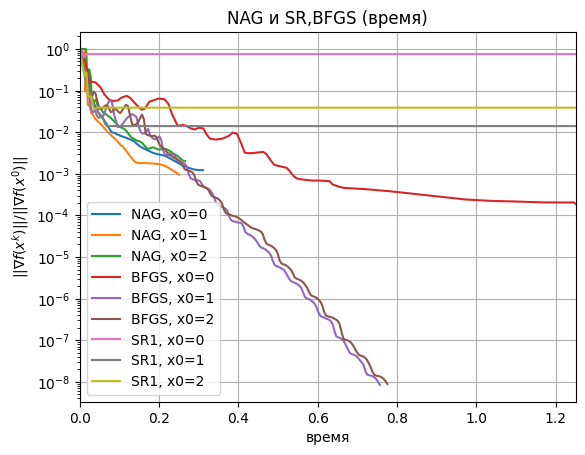

In [94]:
plt.plot(tn0, en0, label='NAG, x0=0')
plt.plot(tn1, en1, label='NAG, x0=1')
plt.plot(tn2, en2, label='NAG, x0=2')
plt.plot(tb0, eb0, label='BFGS, x0=0')
plt.plot(tb1, eb1, label='BFGS, x0=1')
plt.plot(tb2, eb2, label='BFGS, x0=2')
plt.plot(ts0, es0, label='SR1, x0=0')
plt.plot(ts1, es1, label='SR1, x0=1')
plt.plot(ts2, es2, label='SR1, x0=2')

plt.xlabel('время')
plt.ylabel('$||∇f(x^k)||/||∇f(x^0)||$')
plt.title('NAG и SR,BFGS (время)')
plt.grid()
plt.yscale('log')
plt.xlim(0,1.25) #иначе не видно.. внизу оставил скрин без ограничения
plt.legend()
plt.show()